# Prisma AIRS Model Security - Demo

**Status:** ✅ Fully Operational

This notebook demonstrates the complete Prisma AIRS Model Security workflow with the actual working API.

## What You'll Learn

1. ✅ Setup & Authentication
2. ✅ Scanning HuggingFace Models
3. ✅ Understanding Scan Results
4. ✅ Scan History & Analytics
5. ✅ Production Integration Examples

## Prerequisites

- Virtual environment activated: `source ../.venv/bin/activate`
- Credentials in `environment variables` or set in this notebook (don't do that though, use variables)

---

## Section 1: Setup & Authentication

In [1]:
# Import required libraries
import os
from uuid import UUID
from model_security_client.api import ModelSecurityAPIClient
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
# Configure credentials from environment variables
CLIENT_ID = os.getenv('MODEL_SECURITY_CLIENT_ID', '')
CLIENT_SECRET = os.getenv('MODEL_SECURITY_CLIENT_SECRET', '')
TSG_ID = os.getenv('TSG_ID', '')

# Option: Set directly for testing (DO NOT commit real credentials!)
# Uncomment and replace with your values:
# CLIENT_ID = "AIRS@your-tsg-id.iam.panserviceaccount.com"
# CLIENT_SECRET = "your-client-secret-uuid"
# TSG_ID = "your-tsg-id"

# Security Group UUID (get from Strata Cloud Manager)
# Replace with your security group UUID:
HUGGINGFACE_GROUP_UUID = UUID("your-security-group-uuid-here")

# Example format (replace with yours):
# HUGGINGFACE_GROUP_UUID = UUID("12345678-1234-1234-1234-123456789abc")

# Set in environment for SDK
if CLIENT_ID and CLIENT_SECRET and TSG_ID:
    os.environ['MODEL_SECURITY_CLIENT_ID'] = CLIENT_ID
    os.environ['MODEL_SECURITY_CLIENT_SECRET'] = CLIENT_SECRET
    os.environ['TSG_ID'] = TSG_ID
    
    print("✓ Credentials configured")
    print(f"  Client ID: {CLIENT_ID[:20]}...")
    print(f"  TSG_ID: {TSG_ID}")
    print(f"  Security Group: {HUGGINGFACE_GROUP_UUID}")
else:
    print("❌ ERROR: Credentials not configured!")
    print("   Set environment variables or uncomment Option above")

In [3]:
# Initialize Model Security Client
client = ModelSecurityAPIClient(
    base_url="https://api.sase.paloaltonetworks.com/aims"
)

print("✓ Model Security client initialized")
print(f"  Base URL: {client.base_url}")
print(f"\n✅ Ready to scan models!")

✓ Model Security client initialized
  Base URL: https://api.sase.paloaltonetworks.com/aims

✅ Ready to scan models!


---

## Section 2: Your First Model Scan

Let's scan a well-known model from Microsoft.

In [4]:
# Scan Microsoft's DialoGPT model
model_uri = "https://huggingface.co/microsoft/DialoGPT-medium"

print(f"Scanning: {model_uri}")
print("This may take 30-60 seconds...\n")

result = client.scan(
    security_group_uuid=HUGGINGFACE_GROUP_UUID,
    model_uri=model_uri
)

print("="*80)
print("SCAN COMPLETE")
print("="*80)
print(f"\nOutcome: {result.eval_outcome}")
print(f"Scan ID: {result.uuid}")
print(f"Timestamp: {result.created_at}")

if result.eval_summary:
    print(f"\nRules Summary:")
    print(f"  ✓ Passed: {result.eval_summary.rules_passed}")
    print(f"  ✗ Failed: {result.eval_summary.rules_failed}")
    print(f"  Total: {result.eval_summary.total_rules}")

print(f"\nFiles Scanned: {result.total_files_scanned if hasattr(result, 'total_files_scanned') else 'N/A'}")
print(f"Scanner Version: {result.scanner_version if hasattr(result, 'scanner_version') else 'N/A'}")

Scanning: https://huggingface.co/microsoft/DialoGPT-medium
This may take 30-60 seconds...

SCAN COMPLETE

Outcome: EvalOutcome.BLOCKED
Scan ID: b96b4001-927f-4754-83bd-bf97610fdfad
Timestamp: 2025-10-25 01:40:41.665051+00:00

Rules Summary:
  ✓ Passed: 10
  ✗ Failed: 1
  Total: 11

Files Scanned: 12
Scanner Version: 1.6.3


### Understanding the Result

**Important:** The SDK returns summary data only. For detailed violations, you will need to view results in Strata Cloud Manager:

1. Go to: https://strata.paloaltonetworks.com
2. Navigate to: **Insights → Prisma AIRS → Model Security → Scans**
3. Click on your Scan ID (shown above)
4. View:
   - Which specific rules failed
   - Detailed threat descriptions
   - Remediation steps
   - File-level findings

---

## Section 3: Testing Multiple Models

In [5]:
# Test multiple models
test_models = [
    "https://huggingface.co/openai-community/gpt2",
    "https://huggingface.co/google-bert/bert-base-uncased",
    "https://huggingface.co/ykilcher/totally-harmless-model"  # Known vulnerable
]

results = []

for model_uri in test_models:
    print(f"\nScanning: {model_uri.split('/')[-1]}...")
    
    try:
        result = client.scan(
            security_group_uuid=HUGGINGFACE_GROUP_UUID,
            model_uri=model_uri
        )
        
        results.append({
            'model': model_uri.split('/')[-1],
            'outcome': str(result.eval_outcome),
            'rules_passed': result.eval_summary.rules_passed if result.eval_summary else 0,
            'rules_failed': result.eval_summary.rules_failed if result.eval_summary else 0,
            'scan_id': str(result.uuid)
        })
        
        print(f"  Result: {result.eval_outcome}")
        if result.eval_summary:
            print(f"  Rules: {result.eval_summary.rules_passed} passed, {result.eval_summary.rules_failed} failed")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        results.append({
            'model': model_uri.split('/')[-1],
            'outcome': 'ERROR',
            'rules_passed': 0,
            'rules_failed': 0,
            'scan_id': 'N/A'
        })

# Display results as DataFrame
df_results = pd.DataFrame(results)
print("\n" + "="*80)
print("SCAN RESULTS SUMMARY")
print("="*80)
display(df_results)


Scanning: gpt2...
  Result: EvalOutcome.BLOCKED
  Rules: 9 passed, 2 failed

Scanning: bert-base-uncased...
  Result: EvalOutcome.BLOCKED
  Rules: 9 passed, 2 failed

Scanning: totally-harmless-model...
  Result: EvalOutcome.BLOCKED
  Rules: 7 passed, 4 failed

SCAN RESULTS SUMMARY


,model,outcome,rules_passed,rules_failed,scan_id
0,gpt2,EvalOutcome.BLOCKED,9,2,7773c603-def6-4d78-9b44-eec7ded728d6
1,bert-base-uncased,EvalOutcome.BLOCKED,9,2,7e1f0293-f849-44e4-a7a2-cda6efba2eaa
2,totally-harmless-model,EvalOutcome.BLOCKED,7,4,bcb526f6-cf9c-4e3f-aa8d-de436629e6a3


---

## Section 4: Scan History & Analytics

In [6]:
# List recent scans
scans_response = client.list_scans(limit=20)
scans = scans_response.scans

print(f"Retrieved {len(scans)} recent scan(s)\n")

# Create DataFrame for analysis
scans_data = []
for scan in scans:
    scans_data.append({
        'Scan ID': str(scan.uuid)[:8] + '...',  # Shortened for display
        'Model': scan.model_uri.split('/')[-1] if hasattr(scan, 'model_uri') else 'N/A',
        'Outcome': str(scan.eval_outcome),
        'Rules Passed': scan.eval_summary.rules_passed if hasattr(scan, 'eval_summary') and scan.eval_summary else 0,
        'Rules Failed': scan.eval_summary.rules_failed if hasattr(scan, 'eval_summary') and scan.eval_summary else 0,
        'Timestamp': scan.created_at if hasattr(scan, 'created_at') else None
    })

scans_df = pd.DataFrame(scans_data)
display(scans_df.head(10))

Retrieved 14 recent scan(s)



,Scan ID,Model,Outcome,Rules Passed,Rules Failed,Timestamp
0,bcb526f6...,totally-harmless-model,EvalOutcome.BLOCKED,7,4,2025-10-25 01:40:47.505925+00:00
1,7e1f0293...,bert-base-uncased,EvalOutcome.BLOCKED,9,2,2025-10-25 01:40:45.529982+00:00
2,7773c603...,gpt2,EvalOutcome.BLOCKED,9,2,2025-10-25 01:40:43.573904+00:00
3,b96b4001...,DialoGPT-medium,EvalOutcome.BLOCKED,10,1,2025-10-25 01:40:41.665051+00:00
4,312d6b1c...,totally-harmless-model,EvalOutcome.BLOCKED,7,4,2025-10-25 01:29:35.309473+00:00
5,80b92f8b...,DialoGPT-medium,EvalOutcome.BLOCKED,10,1,2025-10-25 01:29:33.285459+00:00
6,31fcad8a...,totally-harmless-model,EvalOutcome.BLOCKED,7,4,2025-10-25 01:23:41.418216+00:00
7,9d3c3377...,DialoGPT-medium,EvalOutcome.BLOCKED,10,1,2025-10-25 01:23:39.469420+00:00
8,a677afbd...,totally-harmless-model,EvalOutcome.BLOCKED,7,4,2025-10-25 01:21:09.217329+00:00
9,8a3a19b1...,DialoGPT-medium,EvalOutcome.BLOCKED,10,1,2025-10-25 01:21:06.991251+00:00


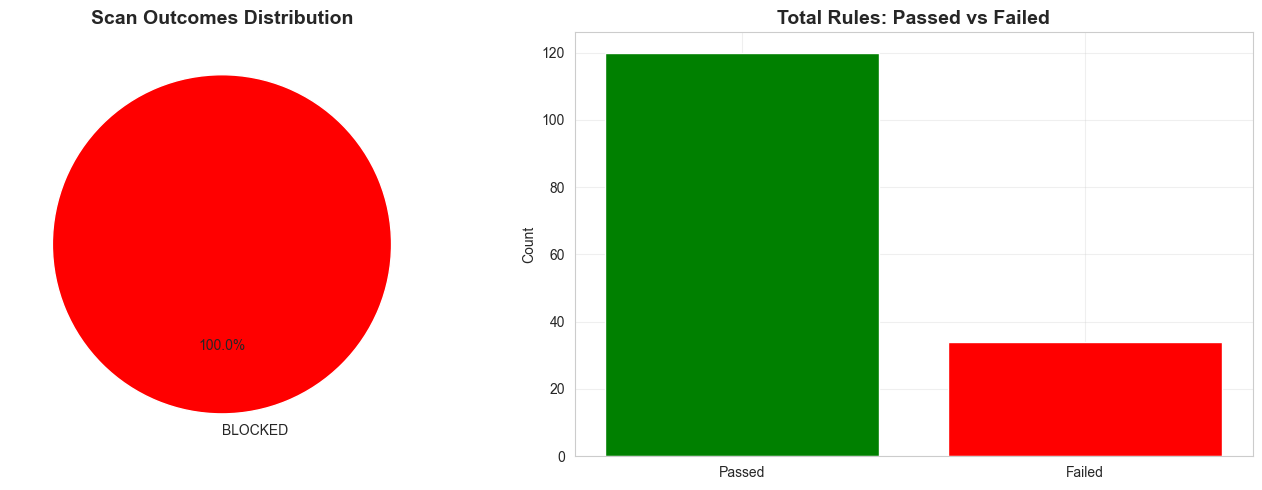

In [7]:
# Visualize scan outcomes
if len(scans_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Outcome distribution
    outcome_counts = scans_df['Outcome'].value_counts()
    colors = {'EvalOutcome.ALLOWED': 'green', 'EvalOutcome.BLOCKED': 'red', 'EvalOutcome.WARNING': 'orange'}
    pie_colors = [colors.get(str(outcome), 'gray') for outcome in outcome_counts.index]
    
    ax1.pie(outcome_counts.values, labels=[str(o).replace('EvalOutcome.', '') for o in outcome_counts.index], 
            autopct='%1.1f%%', colors=pie_colors, startangle=90)
    ax1.set_title('Scan Outcomes Distribution', fontsize=14, fontweight='bold')
    
    # Rules passed vs failed
    rules_data = scans_df[['Rules Passed', 'Rules Failed']].sum()
    ax2.bar(['Passed', 'Failed'], rules_data.values, color=['green', 'red'])
    ax2.set_title('Total Rules: Passed vs Failed', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
else:
    print("No scan data available for visualization")

---

## Section 5: Getting Detailed Scan Information

In [8]:
# Get detailed info for most recent scan
if len(scans) > 0:
    latest_scan = scans[0]
    
    print(f"Fetching detailed information for:")
    print(f"  Scan ID: {latest_scan.uuid}")
    print(f"  Model: {latest_scan.model_uri if hasattr(latest_scan, 'model_uri') else 'N/A'}")
    print()
    
    details = client.get_scan(UUID(str(latest_scan.uuid)))
    
    print("="*80)
    print("DETAILED SCAN INFORMATION")
    print("="*80)
    print(f"\nOutcome: {details.eval_outcome}")
    print(f"Created: {details.created_at}")
    print(f"Updated: {details.updated_at}")
    print(f"\nSecurity Group: {details.security_group_uuid}")
    print(f"Scanner Version: {details.scanner_version}")
    
    if details.eval_summary:
        print(f"\nEvaluation Summary:")
        print(f"  Rules Passed: {details.eval_summary.rules_passed}")
        print(f"  Rules Failed: {details.eval_summary.rules_failed}")
        print(f"  Total Rules: {details.eval_summary.total_rules}")
    
    print(f"\nScan Statistics:")
    print(f"  Files Scanned: {details.total_files_scanned}")
    print(f"  Files Skipped: {details.total_files_skipped}")
    print(f"  Enabled Rules: {details.enabled_rule_count_snapshot}")
    
    if hasattr(details, 'model_formats') and details.model_formats:
        print(f"\nModel Formats Detected:")
        for fmt in details.model_formats:
            print(f"  • {fmt}")
    
    print(f"\n💡 For detailed violation information, view this scan in Strata Cloud Manager:")
    print(f"   Insights → Prisma AIRS → Model Security → Scans → {latest_scan.uuid}")
else:
    print("No scans available")

Fetching detailed information for:
  Scan ID: bcb526f6-cf9c-4e3f-aa8d-de436629e6a3
  Model: https://huggingface.co/ykilcher/totally-harmless-model

DETAILED SCAN INFORMATION

Outcome: EvalOutcome.BLOCKED
Created: 2025-10-25 01:40:47.505925+00:00
Updated: 2025-10-25 01:40:47.646193+00:00

Security Group: ceb2f363-0166-4872-a44e-f92f684f8a09
Scanner Version: 1.6.3

Evaluation Summary:
  Rules Passed: 7
  Rules Failed: 4
  Total Rules: 11

Scan Statistics:
  Files Scanned: 4
  Files Skipped: 0
  Enabled Rules: 11

Model Formats Detected:
  • yaml
  • json
  • zip
  • pytorch_v1_13
  • not_model

💡 For detailed violation information, view this scan in Strata Cloud Manager:
   Insights → Prisma AIRS → Model Security → Scans → bcb526f6-cf9c-4e3f-aa8d-de436629e6a3


---

## Section 6: Advanced Scanning Features

In [9]:
# Scan with custom filters (only scan specific file types)
model_uri = "https://huggingface.co/google-bert/bert-base-uncased"

print(f"Scanning with file filters: {model_uri}")
print("  Only scanning: *.bin, *.json")
print("  Ignoring: *.md, *.txt")
print()

result = client.scan(
    security_group_uuid=HUGGINGFACE_GROUP_UUID,
    model_uri=model_uri,
    allow_patterns=["*.bin", "*.json"],
    ignore_patterns=["*.md", "*.txt"]
)

print(f"Result: {result.eval_outcome}")
print(f"Files scanned: {result.total_files_scanned if hasattr(result, 'total_files_scanned') else 'N/A'}")

Scanning with file filters: https://huggingface.co/google-bert/bert-base-uncased
  Only scanning: *.bin, *.json
  Ignoring: *.md, *.txt

Result: EvalOutcome.BLOCKED
Files scanned: 6


In [10]:
# Scan with custom timeouts (for large models)
result = client.scan(
    security_group_uuid=HUGGINGFACE_GROUP_UUID,
    model_uri="https://huggingface.co/openai-community/gpt2",
    poll_interval_secs=10,      # Check status every 10 seconds
    poll_timeout_secs=900,      # Wait up to 15 minutes
    scan_timeout_secs=900       # Scanner timeout 15 minutes
)

print(f"Scan with extended timeout completed: {result.eval_outcome}")

Scan with extended timeout completed: EvalOutcome.BLOCKED


---

## Section 7: Production Integration Example

In [11]:
# CI/CD Integration Function
def validate_model_for_deployment(model_uri, security_group_uuid, blocking=True):
    """
    Validate a model before deployment.
    
    Args:
        model_uri: HuggingFace model URL
        security_group_uuid: Security group to use
        blocking: If True, fail on violations. If False, warn only.
    
    Returns:
        tuple: (is_safe, scan_result)
    """
    print(f"🔍 Validating: {model_uri}")
    
    try:
        result = client.scan(
            security_group_uuid=security_group_uuid,
            model_uri=model_uri
        )
        
        # Check if model is allowed
        is_safe = str(result.eval_outcome) == 'EvalOutcome.ALLOWED'
        
        if is_safe:
            print("✅ Model PASSED security validation")
            print("   Safe to deploy")
        else:
            print("❌ Model FAILED security validation")
            if result.eval_summary:
                print(f"   Rules failed: {result.eval_summary.rules_failed}/{result.eval_summary.total_rules}")
            
            if blocking:
                print("   🛑 DEPLOYMENT BLOCKED")
            else:
                print("   ⚠️  DEPLOYMENT ALLOWED WITH WARNING")
        
        print(f"   Scan ID: {result.uuid}")
        
        return (is_safe if blocking else True), result
        
    except Exception as e:
        print(f"❌ Scan error: {str(e)}")
        if blocking:
            print("   🛑 DEPLOYMENT BLOCKED (scan failure)")
            return False, None
        else:
            print("   ⚠️  DEPLOYMENT ALLOWED (scan failure, non-blocking)")
            return True, None

# Test the function
print("="*80)
print("PRODUCTION DEPLOYMENT VALIDATION EXAMPLE")
print("="*80)
print()

can_deploy, scan_result = validate_model_for_deployment(
    model_uri="https://huggingface.co/openai-community/gpt2",
    security_group_uuid=HUGGINGFACE_GROUP_UUID,
    blocking=True
)

print(f"\n📊 Deployment Decision: {'APPROVED ✅' if can_deploy else 'REJECTED ❌'}")

PRODUCTION DEPLOYMENT VALIDATION EXAMPLE

🔍 Validating: https://huggingface.co/openai-community/gpt2
❌ Model FAILED security validation
   Rules failed: 2/11
   🛑 DEPLOYMENT BLOCKED
   Scan ID: a51f2c3e-c880-40a2-b3d2-712a65d7ddce

📊 Deployment Decision: REJECTED ❌


---

## Section 8: Export Scan Results

In [12]:
# Export recent scans to CSV
output_file = "scan_results_export.csv"
scans_df.to_csv(output_file, index=False)
print(f"✓ Scan results exported to: {output_file}")

# Export to JSON
json_file = "scan_results_export.json"
scans_df.to_json(json_file, orient='records', indent=2)
print(f"✓ Scan results exported to: {json_file}")

✓ Scan results exported to: scan_results_export.csv
✓ Scan results exported to: scan_results_export.json


---

## Summary & Next Steps

### What We Covered

✅ Setup and authentication with Model Security API  
✅ Scanning HuggingFace models  
✅ Understanding scan results and outcomes  
✅ Scan history and analytics  
✅ Advanced features (filters, timeouts)  
✅ Production deployment validation  
✅ Exporting results  

### Key Learnings

1. **SDK Returns Summary Only** - Detailed violations visible in Strata Cloud Manager
2. **BLOCKED ≠ Malicious** - Models blocked for policy violations (license, format)
3. **Rules Configurable** - Adjust security groups for different risk tolerances
4. **Scanner Works Fast** - Most scans complete in 30-60 seconds
5. **Production Ready** - Can gate deployments based on scan results

### View Detailed Results

📊 **Strata Cloud Manager:** https://strata.paloaltonetworks.com  
📍 **Navigate to:** Insights → Prisma AIRS → Model Security → Scans

### Next Steps

1. **Review scan details** in Strata Cloud Manager
2. **Adjust security group rules** if needed
3. **Scan your own models** (local, S3, Azure)
4. **Integrate into CI/CD** pipeline
5. **Set up Red Teaming** for LLM testing

---

Good Luck!